# Calibration of SEIRD model using Approximate Bayesian Computation (ABC)

Based on code of Lander De Visscher

## Background

### Approximate Bayesian Computation (ABC)
ABC methods are part of **Bayesian methods** for parameter inference. In the Bayesian framework, we base our inference on the **posterior distribution** $P(\theta|y_{obs})$ of a parameter $\theta$ given the observed data $y_{obs}$ (and given the model for which we perform our inference). This conditional probability distribution can be derived from Bayes' theorem:

$$
\begin{equation}
P(\theta|y_{obs}) = \frac{P(y_{obs}|\theta)\,P(\theta)}{P(y_{obs})},
\end{equation}
$$

with 
- $P(y_{obs}|\theta)$ the likelihood function (i.e. how likely it is to observe the data with our model, given the parameter $\theta$),
- $P(\theta)$ the prior distribution (i.e. the probability distribution that reflects our prior believes/the prior evidence of the parameter distribution)
- $P(y_{obs})$ the marginal likelihood.

Since the marginal likelihood $P(y_{obs})$ is often not (analytically) tractable, most Bayesian methods will use the property that the $posterior \propto likelihood \times prior$ in a **sampling algorithm**, that can generate a (approximate) sample from the posterior distribution.

When the likelihood function $P(y_{obs}|\theta)$ is also unknown/intractable but we can generate simulations $y$ with our model given the parameter $\theta$, **Approximate Bayesian Computation** methods come in. **ABC** will approximate the likelihood function as:

$$
p_{\epsilon}(s_{obs}|\theta) = \int K_\epsilon(\parallel s- s_{obs}\parallel)\,p(s|\theta)\mathrm{d} s
$$

The approximations of these methods are twofold.
1. Instead of using the whole (simulated) data $y$, we work with (lower-dimensional) summary statistics $$s = S(y),$$ in which $S$ is the **summary statistics function**.
2. Instead of conditioning on $y = y_{obs}$ (as in the true likelihood), we condition on $$K_\epsilon(\parallel s- s_{obs}\parallel)$$ in which 
    - $K_\epsilon$ is a **smoothing kernel** with **bandwith** $\epsilon$ 
    - $\parallel . - .\parallel$ is a distance metric.

These methods result in an **approximated partial posterior distribution $p_{\epsilon}(\theta|s_{obs})$**. The ABC method is illustrated in the following image (Beaumont 2009).
    
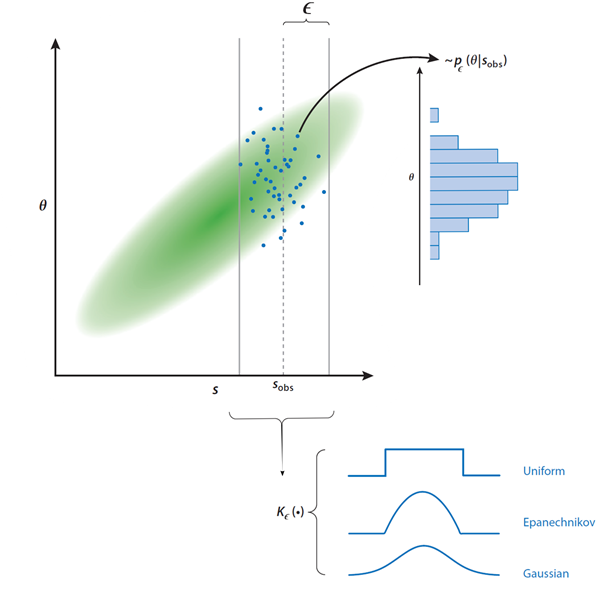

### SMC

In the current implementation ABC inference is performed using **Sequential Markov Chain Monte Carlo (SMC MCMC)**, a variant of ABC where a population of so-called **particles** (which are **weighted samples**) are propagated through intermediate proposal distributions, starting from the **prior distribution $ p(\theta)$**.  These proposal distributions are adaptively constructed during the SMC iterations ($i_{SMC}$) and arise from decreasing the bandwith $\epsilon$ of the smoothing kernel function. The decrease is based on the effective sample size (ESS), which is a measure of the particle degeneracy (i.e. when few particles contain most of the particle weight). 


This amounts to the following procedure:
>- At $i_{SMC} = 0$: $N$ particles are drawn from the **prior** and all particle weights are set to $1/N$.
>- At $i_{SMC} > 0$: 
    1. reweight: $\epsilon$ is reduced so that the ESS is decreased with a fixed (relative) amount $\alpha$
    2. resample: if ESS drops below a specified threshold, $N_{particles}$ particles are drawn from the weighted sample and all particle weights are set to $1/N$.
    3. move: particles $\theta$ with weight > 0 are perturbed with a MCMC kernel and the perturbed particle $\theta'$ is accepted with a probability 
    $$\min\left(1,\frac{K_\epsilon(\parallel s(\theta') - s_{obs} \parallel)\,p(\theta')}{K_\epsilon(\parallel s(\theta) - s_{obs} \parallel) \,p(\theta)}\right) $$
    
**REMARK**: at the moment, code is only usable for **uniform priors**

## Calibration plan

The idea is to perform following calibrations:
- calibration of beta:
    - data: H_in (i.e. daily flow into the hospital)
    - time: first 7 days (i.e. March 15 until 22): period before imposed measures (so when R0 is valid)
- calibration of compliance functions (2 or 3 parameters; indicating how people start adhering to the measures):
    - data: H_in
    - time: first 21 days: period comprising initiation of the measures
- duration of stay in ICU, cohort and recup-after-ICU:
    - data: H_tot
    - time: until some days after the peak

## Initialisations

In [1]:
## For SEIRD model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google, sciensano, polymod, parameters
from covid19model.visualization import output
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
## for ABC
import seaborn as sns

import os
from datetime import datetime

from covid19model.optimization.ABC import ABC
from covid19model.optimization.ABC import store_results
from covid19model.optimization.ABC import metadata
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
modulde_versions_global = metadata.list_module_versions(globals(), return_dict = True)    

numpy 1.18.1
pandas 1.0.3
scipy 1.4.1
matplotlib 3.1.3
networkx 2.4
seaborn 0.10.1


### Seed
Set seed to ensure reproducibility.

In [4]:
sim_seed = 300494
np.random.seed(sim_seed)

### Model parameters

Set SEIRD model parameters.
Following assumptions are made:
- $I_0 = 2$ (first recorded number of infected individuals @ March 1)
- $E_0 = I_0 * 10$ (estimation of initial number of exposed individuals)

In [5]:
params = parameters.get_COVID19_SEIRD_parameters(stratified=False)

In [6]:
initN = model_parameters.get_interaction_matrices()[0]
initN = np.array([initN.sum()])

In [7]:
observed_infections = pd.read_csv('../data/raw/sciensano/ObsInf.txt')

In [8]:
## deaths and recovered pool is negligible on March 15
## about 50% of cases are asymptomatic (hence not tested), so double the amount
initial_infected = observed_infections.iloc[14].item()

In [9]:
levels = initN.size
initial_states = {'S': initN, 'E': np.ones(levels)*initial_infected*9, 
                  'I': np.ones(levels)*initial_infected*6, 'M':np.ones(levels)*initial_infected*3}

In [10]:
# Make time array for simulation (measured in days)
t_start = 0
t_stop =  7
time = t_stop


# Bundle fixed parameters as dict
fixed_model_parameters = {}
fixed_model_parameters["time"] = time
fixed_model_parameters["initial_states"] = initial_states

### Check initial model

**NOTE: momenteel heel weinig inflow in hospital (vgl met bij stratified model)... Vermoedelijk nog iets mis met parameters?**

In [11]:
model = models.COVID19_SEIRD(initial_states, params)

In [12]:
# -> user runs a simulation for a defined time period
chk = {'time':  [42], 
#        'Nc':    [0.3*Nc_home+(1-0.70)*Nc_work + (1-0.80)*Nc_transport]
       'Nc':    [np.array([1])]

      }
out = model.sim(200)

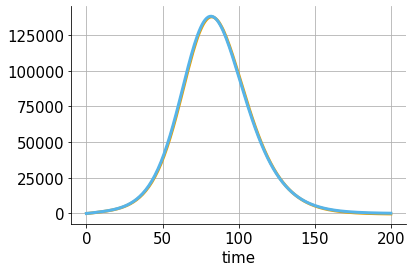

In [13]:
## Sum over stratification only needed for stratified model
(out['H_in'] - out['H_out']).cumsum().sum(dim='stratification').plot()
(out['C']+out['ICU']+out['C_icurec']).sum(dim='stratification').plot()

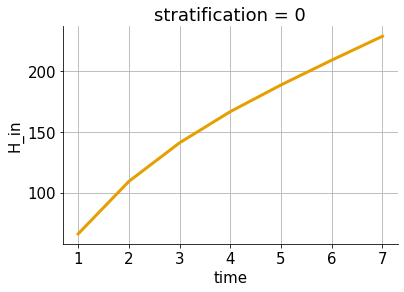

In [14]:
out['H_in'][:, 1:1+time] .plot()

### Summary statistic function
For this example the "summary statistics" are the number of infected, recovered and dead individuals of the first 20 days of the outbreak.

In [15]:
def summary_stat_f(y):
    """
    Selects the infected, recovered and dead individuals of the first 20 days.
    And ravels them to a 1D array.
    """
    return y[:t_stop,:].ravel()

### Load observed data

In [16]:
sciensano_data = sciensano.get_sciensano_COVID19_data(update=False)


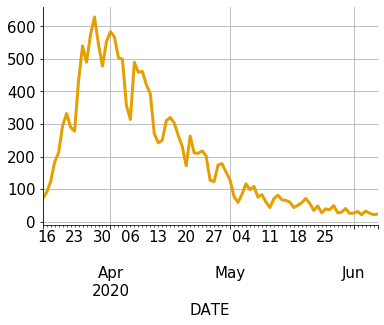

In [17]:
sciensano_data.H_in.plot()

In [18]:
## For calibration of residence durations: use total number of people present in hospital
y_obs_H = sciensano_data.H_tot
## Of calibration of beta and compliance function: use H_in (daily inflow in hospital)
y_obs_H_in = sciensano_data.H_in

In [19]:
y_obs = np.full((y_obs_H_in.shape[0],1),np.nan)
y_obs[:,0] = y_obs_H_in

s_obs = summary_stat_f(y_obs)

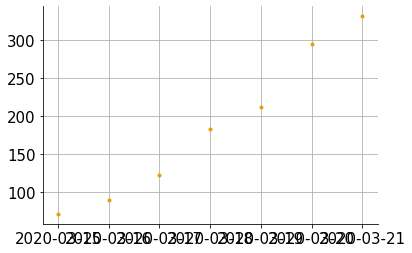

In [20]:
plt.plot(y_obs_H_in[:t_stop], ".")

### ABC hyperparameters
#### Dimensions

In [21]:
n_s = s_obs.shape #shape of summary statistic array
n_particles = 500#1000 # number of particles

#### Priors

In [22]:
#distribution of parameter vectors [beta] # estimate one parameter (on only 7 days)
# if you take more parameters, also fill in min, max values and param_bounds
n_param = 1
theta_min = (0)   # minimum values of uniform priors
theta_max = (1)   # maximum value of prior 
param_bounds = np.array([[0],       # lower parameter bounds
                         [np.nan]]) # upper parameter bounds
def uniform_priors(N_param, theta_min = theta_min, theta_max = theta_max, n_param = n_param):
    """
    Uniform prior distributions for parameter vectors [BETA, GAMMA, OMEGA, DELTA]

    Parameters
    ----------
    N_param : int
        Number of particles to be drawn.
    
    theta_min : ndarray
        minimum values of uniform priors.
        
    theta_max : ndarray
        maximum values of uniform priors.
        
    n_param : int
        number of parameters to be inferred.
        
    Returns
    -------
    param_dist_0
        initial parameter vector distribution.

    """
    theta_min = np.array(theta_min)
    theta_max = np.array(theta_max)
    return np.random.uniform(theta_min, theta_max, (N_param,n_param))

#### Construct generative function

In [23]:
def GM_dist(params_dist,
       n_draws_per_param,
       summary_stat_f,
       n_s,
       time,
       initial_states):
    """
    Generative model for the SEIRD epidemic model.
    The outputs that are generated are the specified summary statistics of the
    model output.

    Parameters
    ----------
    params_dist : ndarray,
        array containing distribution of parameter vectors [BETA, GAMMA, OMEGA, DELTA] of the SEIRD model
    n_draws_per_param : int,
        number of times the simulated data are generated per parameter vector
    summary_stat_f : JIT-compiled function:
        summary statistic of model outputs
    n_s :
        shape of the summary statistic array
    t_vec : ndarray
        sequence of time points for which to solve for the system of equations
    y_0 : ndarray
        number of generations

    Returns
    -------
    stat_dist : ndarray
        distribution of summary statistics of model outputs, generated with
        the distribution of parameter vectors.
    """
    N = params_dist.shape[0]
    stat_dist = np.empty((N, n_draws_per_param, *n_s))
    for i in range(0,N):
        current_params = params_dist[i]
        params['beta'] = current_params[0]
        model = models.COVID19_SEIRD(initial_states, params)
        out = model.sim(time)
        y = np.full((time,1),np.nan)
        y[:,0] = out['H_in'][:, 1:1+time]
        stat_dist[i,:,:] = summary_stat_f(y)
    return stat_dist


#### Create SMC_MCMC object
The ABC module contains the class `SMC_MCMC` which, upon creation, sets all necessary hyperparameters and functions as attributes/methods.
To make an SMC_MCMC object, you have to provide at least the following:
- `generative_model` : a function that accepts following arguments 
    - `params_dist` : the particle distribution (i.e. `n_particles` parameter vectors of size length `n_param`
    - `n_draws_per_param` : number of times the simulated data are generated per parameter vector (for deterministic models, use 1)
    - `summary_stat_f` : summary statistic function
    - `n_s` : shape (tuple) of the summary statistic array
    - some fixed model parameters 
 
- `priors` : function that can draw particles from the prior distribution (**REMARK**: at the moment, code is only usable for **uniform priors**)
- `n_param` : number of parameters that are to be inferred
- `y_obs` : observed outputs
- `summary_stat_f` : summary statistic function

Next to that, additional hyperparameters can be set:

- `ESS_min_factor` : ESS threshold for resampling (= fraction of n_particles). If ESS goes under this threshold, the parameters are resampled
- `fixed_model_parameters` : arguments of the `generative_model` that are fixed during calibration
- `max_SMC_iter`: maximum number of SMC iterations
- `distance_f` : distance function to be used (here Euclidean distance), custom functions can be used directly or added to the distances.py module
- `smoothing_kernel_f`: function to be used as smoothing kernel (-> gaussian leads to smoother behaviour than uniform)
- `alpha_ESS`: factor to decrease the ESS at every iteration (keep around 0.9). This factor determines how much the sample size decreases at each iteration. The closer to 1, the slower it goes (but possibly more precise).

Lastly, some words on the MCMC kernel (used in the move step). This is implemented as a separate class, of which the attributes are passed in the dict `MCMC_kernel_specifics`.
To ensure convergence, the scale of the parameter perturbation also needs to decrease during iterations. 
When the mode `dynamic_param_dist_range` is selected, the scale is set as a fraction (`r_MCMC`) of the range of particles with weights above 0.
Finally, the range of the parameters can be bounded (see -> priors).

In [24]:
covid_ABC = ABC.SMC_MCMC(GM_dist, #SEIRD.GM_dist
                              priors = uniform_priors,
                              n_param = n_param,
                              y_obs = y_obs,
                              summary_stat_f = summary_stat_f,
                              s_obs = False, 
                              ESS_min_factor = 0.5,
                              n_particles = n_particles,
                              n_draws_per_param = 1, 
                              fixed_model_parameters = fixed_model_parameters,
                              max_SMC_iter = 151,
                              zero_tol = 5e-4,
                              distance_f = "Euclidean",
                              smoothing_kernel_f = "gaussian",
                              alpha_ESS = 0.9,
                              MCMC_kernel_specifics = {
                                  "kernel_f" : "gaussian",
                                  "scale_mode":"dynamic_param_dist_range", 
                                  "r_MCMC" : 0.05,
                                  "bounds" : param_bounds})

### Create results folder

In [25]:
obs_group = "COVID19_BE"
timestamp = str(datetime.now()).replace(":","-").split(".")[0]
results_folder = f"SMC_{timestamp}_withoutdiff"
results_path = os.path.join("..","results","COVID19", obs_group, "demo", results_folder)


## Run ABC

In [26]:
# =============================================================================
# %% Run algorithm
# =============================================================================
param_distributions, weight_distributions, ABC_bandwiths = covid_ABC.run(results_path,seed = sim_seed)

INFO:root:
Approximate Bayesian Computation

Version:                                       [try_out_nodiff]-let SEIRD_model output H_in and H_out-ba478789d2ab08a64bf796b36074588234ca3d86
SMC-MCMC algorithm started at                  2020-06-19 09:00:41.434572
with seed 300494
                                
INFO:root:iter	 bandwith	ESS
INFO:root:  0	  133334.62	500	
INFO:root:  1	   49263.44	450:             490 particles moved of the  500 candidates
INFO:root:  2	   38724.78	405:             442 particles moved of the  448 candidates
INFO:root:  3	   31935.71	364:             378 particles moved of the  394 candidates
INFO:root:  4	   26456.35	328:             349 particles moved of the  361 candidates
INFO:root:  5	   21669.05	295:             320 particles moved of the  329 candidates
INFO:root:  6	   17298.85	266:             284 particles moved of the  291 candidates
INFO:root:  7	   13386.54	239: (resample)  492 particles moved of the  500 candidates
INFO:root:  8	    7843.23	

If the algorithm is terminated before the maximum nuber of iterations is reached, this is probably due to issues with the decreasing the bandwith below the (unknown) minimum. Use the particle distribution of the iteration before the last resample as end result.

In [27]:
# =============================================================================
# %% Write results
# =============================================================================
metadata_dict = metadata.get_metadata_from_attributes(covid_ABC,
                                                      skip_attributes = ["param_distributions","weight_distributions","ABC_bandwiths", "logger_header", "logger_sim"],
                                                      custom_classes = {ABC.MCMC_kernel : lambda x : metadata.get_metadata_from_attributes(x,skip_attributes = ["MCMC_object"]),
                                                                        datetime : lambda x : str(x)})
metadata_dict["modulde_versions_global"] = modulde_versions_global

file_path = store_results.write_results_hdf5(
    os.path.join(results_path,results_folder),
                                 metadata_dict,
                                 param_distributions = param_distributions,
                                 weight_distributions = weight_distributions,
                                 ABC_bandwiths = ABC_bandwiths)

In [ ]:
## read in previous data
# param_distributions, metadata_dict, ABC_bandwiths = store_results.load_results_hdf5(
#     results_path, ["param_distributions","weight_distributions","ABC_bandwiths"])

## Plot results

### diagnostic plots of ABC convergence

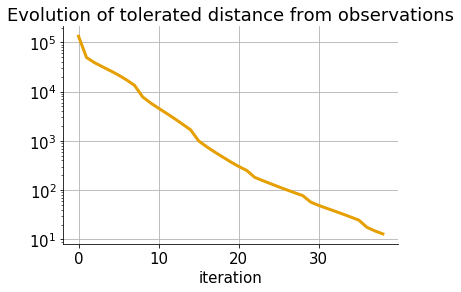

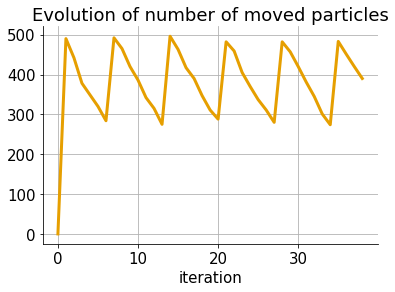

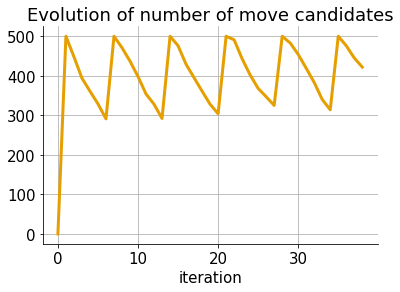

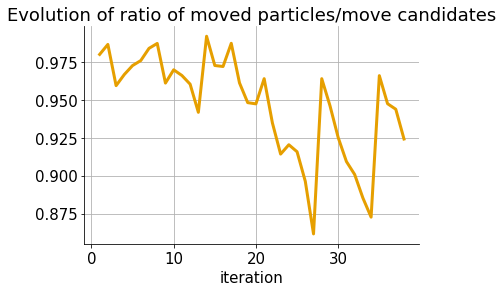

In [28]:
plt.figure()
plt.semilogy(ABC_bandwiths)
plt.title("Evolution of tolerated distance from observations")
plt.xlabel("iteration")

plt.figure()
plt.title("Evolution of number of moved particles")
plt.xlabel("iteration")
plt.plot(covid_ABC.moved_particles[:covid_ABC.i_SMC])

plt.figure()
plt.title("Evolution of number of move candidates")
plt.xlabel("iteration")
plt.plot(covid_ABC.move_candidates[:covid_ABC.i_SMC])

plt.figure()
plt.title("Evolution of ratio of moved particles/move candidates")
plt.xlabel("iteration")
plt.plot(covid_ABC.moved_particles[:covid_ABC.i_SMC]/covid_ABC.move_candidates[:covid_ABC.i_SMC])

### Plots of marginal posterior parameter distributions
First, select SMC iteration. (before break)

In [29]:
i_SMC = param_distributions.shape[0]-3
print(i_SMC)

36


Plot parameter distributions.

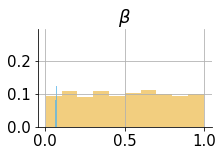

In [30]:
parameter_names = ["$\\beta$"]
plt.figure()
for i in range(1):
    plt.subplot(2,2,i+1)
    plt.title(parameter_names[i])
    plt.hist(param_distributions[0,:,i], weights = weight_distributions[0,:]/np.sum( weight_distributions[0,:]), alpha = 0.5)
    plt.hist(param_distributions[i_SMC,:,i], weights = weight_distributions[i_SMC,:]/np.sum( weight_distributions[i_SMC,:]),alpha = 0.75)
plt.tight_layout()
plt.savefig(os.path.join(results_path,f"param_dist_iSMC{i_SMC}.png"),bbox_inches = "tight")

### plot simulations with posterior

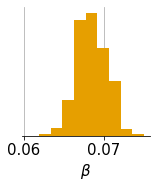

In [31]:
posterior = param_distributions[i_SMC,:]
norm_weights = weight_distributions[i_SMC,:]/np.sum(weight_distributions[i_SMC,:])
g = sns.pairplot(pd.DataFrame(posterior, columns = parameter_names),
                 diag_kind="hist", 
                 diag_kws = {"weights": norm_weights },
                 plot_kws= {"size": norm_weights, "alpha" : 0.05, "markers" : ".", "edgecolor" : "tab:blue"},
                 corner=True)
g.savefig(os.path.join(results_path,f"param_pairplot_iSMC{i_SMC}.png"))

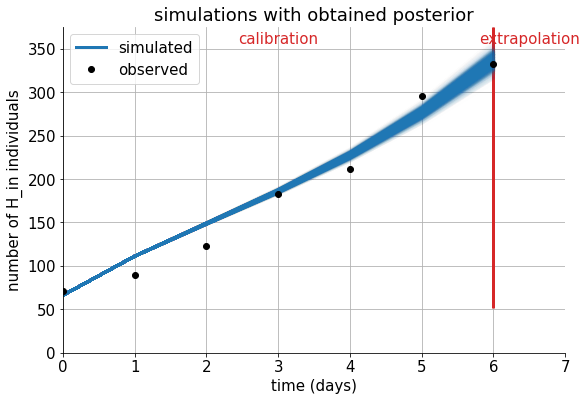

In [35]:
t_stop_sim = 7
tStop = 7 # calibration until 7
y_sim = GM_dist(posterior,               # parameters
                      1,                 # n_draws_per_parameter
                      lambda y : y,      # return raw simulation outputs
                      (t_stop_sim,5), 
                      t_stop_sim,    # t_vec
                      initial_states)    # inital conditions

for subpop in ["H_in"]:
     fig,ax = plot_full_posterior_sim(y_obs,y_sim, norm_weights/np.max(norm_weights), t_stop_sim, subpop, tStop, alpha_scale = 0.05)
     fig.savefig(os.path.join(results_path,f"postsim_iSMC{i_SMC}_{subpop}.png"))

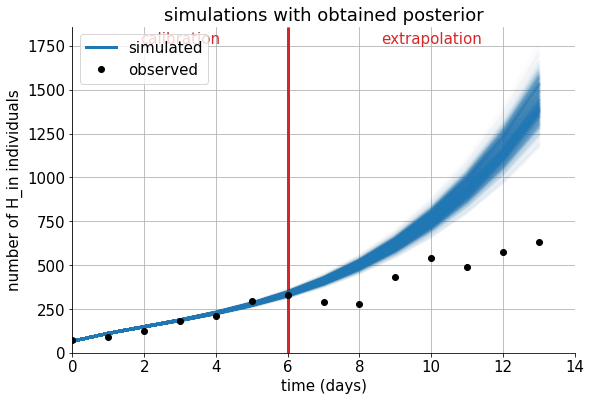

In [36]:
t_stop_sim = 14
tStop = 7 # calibration until 7
y_sim = GM_dist(posterior,               # parameters
                      1,                 # n_draws_per_parameter
                      lambda y : y,      # return raw simulation outputs
                      (t_stop_sim,5), 
                      t_stop_sim,    # t_vec
                      initial_states)    # inital conditions
for subpop in ["H_in"]:
     fig,ax = plot_full_posterior_sim(y_obs,y_sim, norm_weights/np.max(norm_weights), t_stop_sim, subpop, tStop, alpha_scale = 0.05)
     fig.savefig(os.path.join(results_path,f"postsim_iSMC{i_SMC}_{subpop}_extrapol.png"))


In [34]:
def plot_full_posterior_sim(y_obs, y_sim, norm_weights, t_stop_sim, subpop, t_stop_cal = None, **kwargs):
    """
    Plot simulations of the posterior parameter distribution.

    The results are plotted for a given subpopulation of the results ("susceptible",
    "exposed","infected","recovered", or "dead) and from t_0 = 0 to t_stop_sim

    Parameters
    ----------
    y_obs : ndarray
        observed populations; shape = (n_timesteps, 4)
    y_sim : ndarray
        simulated populations, output from GM_dist
    norm_weights :  normalised weights
        :
    t_stop_sim : int
        time step at which simulations are stopped.
    subpop : str, optional
        "susceptible","exposed","infected","recovered", or "dead. The default is "infected".
    t_stop_cal : int, optional
        if given, this is the last time step used in the calibration
    Returns
    -------
    fig, ax:
        handles to figure and axes

    """

    alpha_vect = norm_weights if "alpha_scale" not in kwargs else norm_weights * kwargs["alpha_scale"]

    i_subpop = {"H_in":0,"H_tot":1}[subpop]
    fig = plt.figure(figsize = (9,6))
    ax = plt.gca()
    n_sim = y_sim.shape[0]
    for i in range(n_sim):
        plt.plot(y_sim[i,0,:,i_subpop],
                 color = "tab:blue",
                 alpha = alpha_vect[i])
    obs_plt, = plt.plot(y_obs[:t_stop_sim,i_subpop],"o", color= "black")
    sim_plt = matplotlib.lines.Line2D([0],[0], color = "tab:blue")
    y_lim = ax.get_ylim()
    if t_stop_cal is not None:
        # plot which data are used for calibration.
        plt.vlines(t_stop_cal-1, y_lim[0], y_lim[1] , "tab:red")
        plt.text((t_stop_cal-1)/2, 0.95*y_lim[1], "calibration", horizontalalignment='center', color = "tab:red")
        plt.text(t_stop_cal-0.5 + (t_stop_sim-t_stop_cal)/2, 0.95*y_lim[1], "extrapolation",horizontalalignment='center', color = "tab:red")
    ax.set_ylim((0,y_lim[1]))
    ax.set_xlim((0,t_stop_sim))
    plt.legend((sim_plt,obs_plt),("simulated", "observed"))
    plt.title("simulations with obtained posterior")
    plt.xlabel("time (days)")
    plt.ylabel(f"number of {subpop} individuals")
    return fig, ax
